# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

**Цель** - исследовать данные и установить параметры, влияющие на цену объектов. *Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.*

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

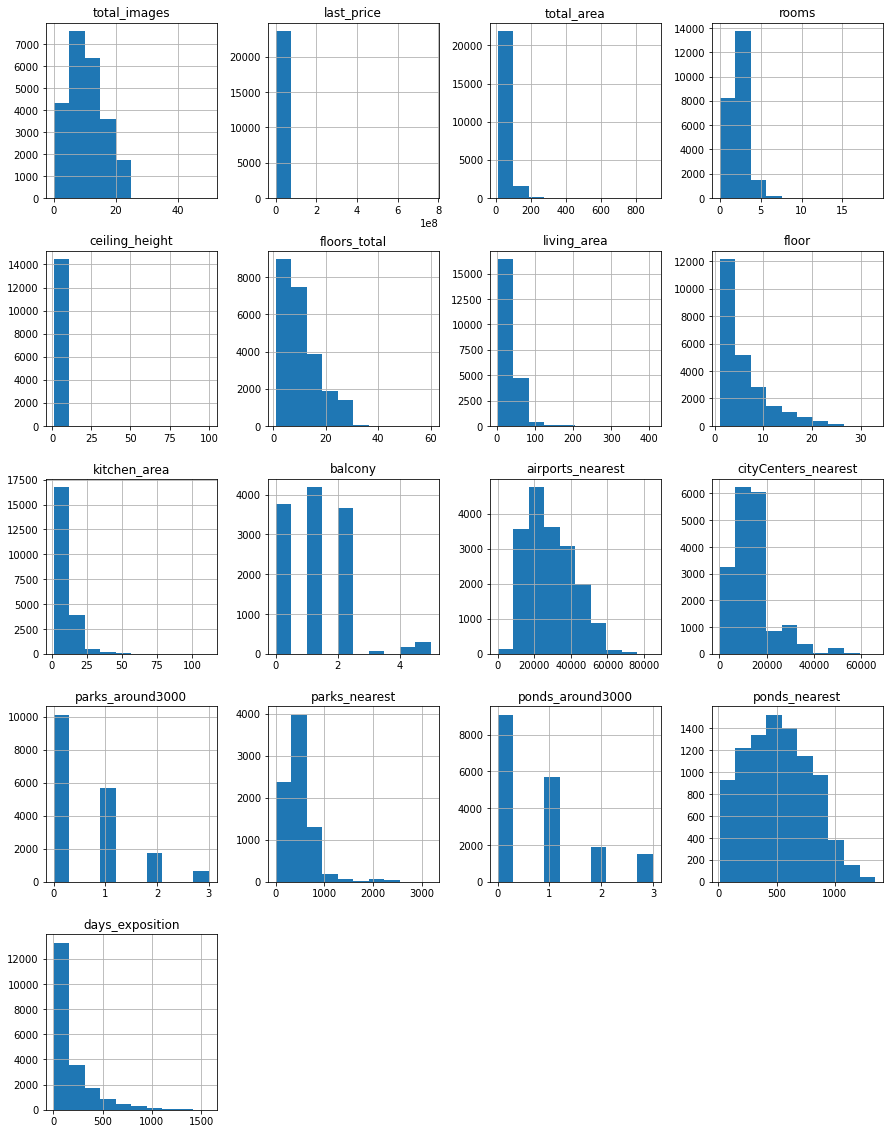

In [4]:
data.hist(figsize=(15, 20));

In [5]:
#для собственного понимания, за какой период предоставлена выгрузка
print(f'саммая ранняя дата - {data.first_day_exposition.min()}, самая поздняя дата - {data.first_day_exposition.max()}')

саммая ранняя дата - 2014-11-27T00:00:00, самая поздняя дата - 2019-05-03T00:00:00


Предоставленная выгрузка с данными о продаже квартир в перид с конца ноября 2014 по начало мая 2019 содержит **23699 объявлений**.

Сразу можно заметить следующие проблемы с данными в выгрузке:

1) присутствуют столбцы с пропущенными значениями:  
-	ceiling_height
-	floors_total
-	living_area
-	is_apartment
-	kitchen_area
-	balcony
-	locality_name
-	airports_nearest
-	cityCenters_nearest
-	parks_around3000
-	parks_nearest
-	ponds_around3000
-	ponds_nearest
-	days_exposition

2) присутствуют выбросы в столбцах
-   total_area
-   living_area
-   kitchen_area
-   last price
-   ceiling_height

3) есть столбцы, в которых нужно изменить тип данных:
-	first_day_exposition на datetime
-	floors_total на int
-	is_apartment на boolean
-	balcony на int
-	parks_around3000 на int
-	ponds_around3000 на int


### Выполните предобработку данных

#### Обработка пропусков

In [6]:
#Определим, в каких столбцах есть пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

##### Пропуски в столбце  `ceiling_height`

**Пропуски в столбце `ceiling_height`** можно было бы заменить медианным значением высоты потолка, но поскольку в этом столбце содержатся выбросы, то заполнением пропусков займемся ***после предобработки данных***.

*Пропуски могли появиться как по вине пользователя (не заполнил соответствующее поле в объявлении на продажу), так и из-за технической ошибки при записи данных.*

##### Пропуски в столбцах  `floors_total`, `locality_name`

Поскольку логично предположить, что этажность застройки в Санкт-Петербурге и в поселках/деревнях может существенно отличаться, то **пропуски в столбце `floors_total`** будем заменять самым распространенным значением кол-ва этажей в конкретном населенном пункте, т.е. модой.  

***Но тогда сперва нам нужно найти и устранить неявные дубликаты в столбце с названием населенного пункта `'locality_name'`***

In [7]:
#Изучим уникальные значения в столбце с названиями 
print('Кол-во уникальных значений в столбце locality_name:', data['locality_name'].nunique(), '\n', data['locality_name'].sort_values().unique())

Кол-во уникальных значений в столбце locality_name: 364 
 ['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 

In [8]:
# удалим неявные дубликаты в столбце locality_name, для этого сначала заменим ё на е, а затем уберем из названий тип населенного пункта (деревня/поселок/село и тд), оставив только название
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок', 'коттеджный поселок', 'деревня','поселок при железнодорожной станции', 'поселок станции', 'садовое товарищество', 'поселок', 'село', 'садоводческое некоммерческое товарищество' ], '', regex=True)
    .str.strip()
) 
print('Кол-во уникальных значений в столбце locality_name после удаления дубликатов:',data['locality_name'].nunique(), '\n',data['locality_name'].sort_values().unique())


Кол-во уникальных значений в столбце locality_name после удаления дубликатов: 305 
 ['Агалатово' 'Александровская' 'Алексеевка' 'Аннино' 'Аро' 'Барышево'
 'Батово' 'Бегуницы' 'Белогорка' 'Белоостров' 'Бокситогорск'
 'Большая Вруда' 'Большая Ижора' 'Большая Пустомержа' 'Большие Колпаны'
 'Большое Рейзино' 'Большой Сабск' 'Бор' 'Борисова Грива' 'Бугры'
 'Будогощь' 'Ваганово' 'Важины' 'Вартемяги' 'Вахнова Кара' 'Вещево'
 'Виллози' 'Вознесенье' 'Возрождение' 'Войсковицы' 'Войскорово'
 'Володарское' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Вырица'
 'Выскатка' 'Высокоключевой' 'Высоцк' 'Гаврилово' 'Гарболово' 'Гатчина'
 'Гладкое' 'Глажево' 'Глебычево' 'Глинка' 'Гончарово' 'Горбунки'
 'Гостилицы' 'Громово' 'Дзержинского' 'Дружная Горка' 'Дружноселье'
 'Дубровка' 'Елизаветино' 'Ефимовский' 'Жил' 'Жилгородок' 'Житково'
 'Заводской' 'Заклинье' 'Заневка' 'Запорожское' 'Зеленогорск' 'Зимитицы'
 'Ивангород' 'Извара' 'Ильичево' 'Иссад' 'Калитино' 'Каложицы' 'Кальтино'
 'Каменногорск' 'Камышовка' '

Кажется, что неявных дубликатов в столбце с названиями населенных пунктов больше не осталось. Но есть записи, в которых ***населенный пункт пропущен***. 

Вообще пропуски в названии населенного пункта в объявлениях о продаже недвижимости выглядят странно, т.к. населенный пункт, в котором находится недвижимость, - это один из самых важных критериев для потенциального покупателя. Кажется логичным, чтобы поле с названием населенного пункта для заполнения продавцом являлось обязательным, и, *вероятно, пропуски возникли из-за технических ошибок, например, при переносе данных из таблицы в таблицу/объединении разных таблиц и т.д.*

In [9]:
print('Таких записей немного: всего', data.locality_name.isna().sum(), 'с пропусками из', data.shape[0], 'записей.', '\n', 'Удаление такого количества записей не исказит наши выводы, поэтому удалим строки, в которых название населенного пункта пропущено и удостоверимся, что пропусков больше нет ')
data.dropna(subset = ['locality_name'], inplace = True)
print('Осталось строк с пропусками:', data.query('locality_name.isna()').shape[0])

Таких записей немного: всего 49 с пропусками из 23699 записей. 
 Удаление такого количества записей не исказит наши выводы, поэтому удалим строки, в которых название населенного пункта пропущено и удостоверимся, что пропусков больше нет 
Осталось строк с пропусками: 0


Теперь вернемся к **обработке пропусков в кол-ве этажей в доме.**

In [10]:
#посмотрим, для каких населенных пунктов в объявлениях пропущено кол-во этажей в доме
data.loc[data.floors_total.isna(), 'locality_name'].value_counts()

Санкт-Петербург    70
Мурино              4
Красное Село        2
Кудрово             2
Шушары              1
Бугры               1
Новое Девяткино     1
Щеглово             1
Стрельна            1
Новоселье           1
Токсово             1
Name: locality_name, dtype: int64

Как уже предполагали выше, этажность дома ***можно заменить самым распространенным значением количества этажей в домах для данного населенного пункта.***

*Учтем при этом, что этаж квартиры, указанный в объявлении не может быть больше, чем всего этажей в доме. Для таких случаев (если они есть) предположим, что этаж в объявлении равен общему кол-ву этажей в доме (т.е. последний).*

В таком подходе, однако, видится *проблема для пропусков в петербургских объявлениях* (а большинство пропусков именно в них): из-за того, что город большой, этажность будет зависеть от района (в историческом центре нет высоток, а на окраинах города в новых районах, наоборот, больше высотных зданий, чем низкоэтажных). 

Ниже посмотрим:
- как зависит кол-во этажей от удаленности от центра в Санкт-Петербурге (действительно ли есть кластеры)
- на какой удаленности от центра находятся квартиры в СПБ с пропущенными значениями в столбце total_floors (сколько квартир попадает в каждый кластер)

На основании этого решим, стоит ли дробить СПБ на кластеры, отдельно для каждой группы считать моды и заполнять пропуски модами на основании удаленности от центра, или можно ограничиться одной модой без значительного искажения результатов.

<AxesSubplot:xlabel='cityCenters_nearest', ylabel='floors_total'>

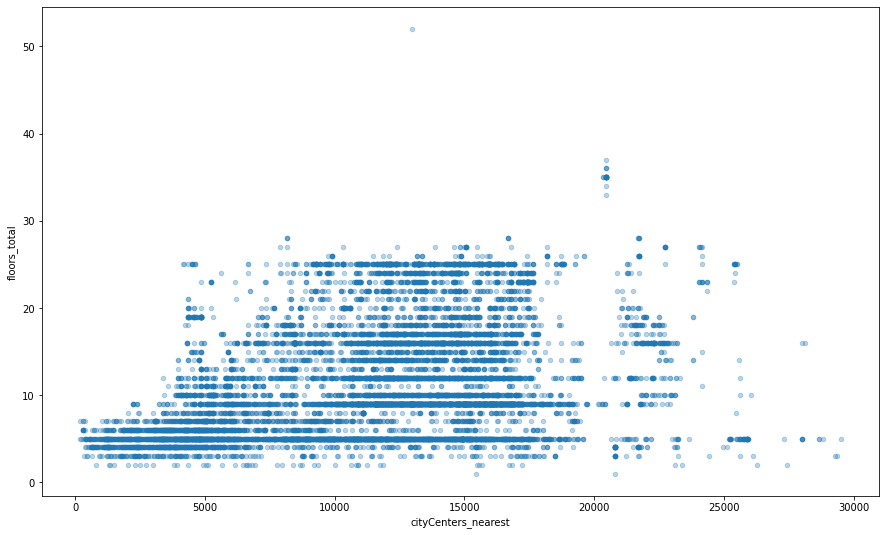

In [11]:
(
    data
    .query('locality_name == "Санкт-Петербург"')
    .plot(kind = 'scatter', x = 'cityCenters_nearest', y = 'floors_total',  alpha = .3, figsize = (15,9))
)

Действительно, даже не углубляясь сильно в анализ, можно увидеть, что в зоне до 4км от центра все дома не выше 10 этажей, а в зоне >4км от центра больше высоток.

Посмотрим, много ли квартир с пропусками в total_floors, находящихся менее чем в 4 км от центра.

<AxesSubplot:>

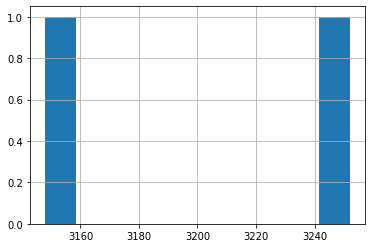

In [12]:
(
    data
    .loc[(data.floors_total.isna()) & (data.locality_name == 'Санкт-Петербург') & (data.cityCenters_nearest < 4e3), 'cityCenters_nearest']
    .hist()
)

Всего 2 квартиры, для которых не заполнено значение floors_total, расположены в центре СПБ, поэтому не будем дополнительно дробить данные по этажности зданий в СПБ на кластеры, это не исказит наши выводы.

In [13]:
# Создадим таблицу, в которой будут храниться моды кол-ва этаже в домах для каждого населенного пункта
floors_mods = data.pivot_table(index = 'locality_name', values = 'floors_total', aggfunc = lambda x: x.mode().iat[0]).reset_index()

# Пройдем циклом по всем пропускам в столбце floors_total и заменим их соответстующей модой или этажом квартиры, если этаж квартиры больше медианы
for index,row in data.query('floors_total.isna()').iterrows():
    try:
        data.loc[index,'floors_total'] = floors_mods[floors_mods.locality_name == data.loc[index,'locality_name']]['floors_total'].values[0]
        data.loc[index,'floors_total'] = max(data.loc[index,'floors_total'], data.loc[index,'floor'])
    except:
        pass
# Удостоверимся, что пропусков не осталось                                                        
print('Кол-во пропусков в колонке floors_total после обработки:', data.floors_total.isna().sum())                                               

Кол-во пропусков в колонке floors_total после обработки: 0


##### Пропуски в столбцах `living_area`, `kitchen_area`

Заполним пропуски позже, после этапа предобработки данных.

##### Пропуски в столбце `balcony`

Пропуски в столбце `balcony`, вероятно, появились из-за того, что *продавец не заполнил соответствующее поле в объявлении*. А не заполнил, вероятно, потому как балконов нет. ***Заменим пропуски на 0.***

In [14]:
data['balcony'].fillna(0, inplace = True)
data['balcony'].isna().sum() #проверяем, что пропусков не осталось

0

##### Пропуски в столбце `is_apartment`

Пропуски в столбце `is_apartment`, вероятно, появились из-за того, что *продавец не заполнил соответствующее поле в объявлении*. Незаполненное поле, вероятно, означает - нет, не апартаменты. ***Заменим пропуски на False.***

In [15]:
data['is_apartment'].fillna(False, inplace = True)
data['is_apartment'].isna().sum() #проверяем, что пропусков не осталось

0

##### Пропуски в столбцах `airports_nearest`, `cityCenters_nearest`

Поскольку столбцы  `airports_nearest` и `cityCenters_nearest` заполняются автоматически данными из геосервисов, то пропуски в них появились, вероятно, изза того, что картографические данные для указанного в объявлении адреса отсутствовали в справочнике с картографическими данными.

Заменим пропуски в столбцах `airports_nearest` и `cityCenters_nearest` соответствующими медианными значениями расстояний для конкретного населенного пункта (если возможно)

In [16]:
# Посмотрим, сколько пропусков было изначально в данных    
print ('Кол-во пропусков в столбце airports_nearest до обработки:', data.airports_nearest.isna().sum())
print ('Кол-во пропусков в столбце cityCenters_nearest до обработки:' , data.cityCenters_nearest.isna().sum())

Кол-во пропусков в столбце airports_nearest до обработки: 5534
Кол-во пропусков в столбце cityCenters_nearest до обработки: 5511


In [17]:
# Создадим таблицу, в которой будут храниться медианные значения расстояний для каждого населенного пункта
airport_center_median = data[['locality_name','airports_nearest', 'cityCenters_nearest']].pivot_table(index = 'locality_name', values = ['airports_nearest', 'cityCenters_nearest'], aggfunc = 'median').reset_index()

# Пройдем циклом по всем пропускам в столбцах и заменим их соответстующими медианами
for index, row in data.query('airports_nearest.isna()').iterrows():
    try:
        data.loc[index,'airports_nearest'] = airport_center_median[airport_center_median.locality_name == row['locality_name']]['airports_nearest'].values[0]
    except:
        pass

for index, row in data.query('cityCenters_nearest.isna()').iterrows():
    try:
        data.loc[index,'cityCenters_nearest'] = airport_center_median[airport_center_median.locality_name == row['locality_name']]['cityCenters_nearest'].values[0]
    except:
        pass
    
# Посмотрим, сколько пропусков осталось после работы цикла    
print ('Кол-во пропусков в столбце airports_nearest после обработки:', data.airports_nearest.isna().sum())
print ('Кол-во пропусков в столбце cityCenters_nearest после обработки:' , data.cityCenters_nearest.isna().sum())

Кол-во пропусков в столбце airports_nearest после обработки: 4829
Кол-во пропусков в столбце cityCenters_nearest после обработки: 4829


Часть пропусков удалось заполнить, но пропущенных значений все равно осталось еще много. *Оставим записи с пропусками, т.к. для их заполнения необходимо запрашивать дополнительные данные.*

In [18]:
#data.loc[data.airports_nearest.isna(), 'locality_name'].value_counts().head(10).sum() #как вариант, для топ-10 локаций подтянуть данные из гугл, но достаточно трудозатратно, поэтому пока оставляем как есть

##### Пропуски в столбцах `parks_nearest`, `ponds_nearest`, `parks_around3000`, `ponds_around3000`

Значения в столбцах `parks_nearest` и `ponds_nearest` - это значения, заполненные самим пользователем. ***Продавец мог оставить данные незаполненными, имея в виду, что парков и прудов поблизости нет.*** 

Проверим данную гипотезу, сопоставив пропуски в столбцах `parks_nearest` и `ponds_nearest` со значениями в столбцах `parks_around3000`, `ponds_around3000`, которые заполняются автоматически данными из геосервисов *(в `parks_around3000`, `ponds_around3000`должны быть нули, чтобы наша гипотеза подтвердилась).*

In [19]:
print('Значения в колонке parks_around3000 в строках с пропусками в parks_nearest:','\n', data[data['parks_nearest'].isna()]['parks_around3000'].value_counts(dropna = False))
print('Значения в колонке ponds_around3000 в строках с пропусками в ponds_nearest:','\n', data[data['ponds_nearest'].isna()]['ponds_around3000'].value_counts(dropna = False))

Значения в колонке parks_around3000 в строках с пропусками в parks_nearest: 
 0.0    10076
NaN     5510
Name: parks_around3000, dtype: int64
Значения в колонке ponds_around3000 в строках с пропусками в ponds_nearest: 
 0.0    9055
NaN    5510
Name: ponds_around3000, dtype: int64


Действительно, *в основном пропускам в столбцах с кол-вом парков и прудов соответстуют нулевые значения в соответствующих столбцах, заполненных автоматически.*

Предположим, что наша гипотеза верна, тогда избавимся и от пропусков в столбцах `parks_around3000` и `ponds_around3000` - заменим их нулями.

In [20]:
data['parks_nearest'].fillna(0, inplace = True)
data['ponds_nearest'].fillna(0, inplace = True)

data['parks_around3000'].fillna(0, inplace = True)
data['ponds_around3000'].fillna(0, inplace = True)
     
print("Кол-во пропусков после обработки:", '\n', data[['parks_nearest', 'ponds_nearest', 'parks_around3000', 'ponds_around3000']].isna().sum())

Кол-во пропусков после обработки: 
 parks_nearest       0
ponds_nearest       0
parks_around3000    0
ponds_around3000    0
dtype: int64


##### Пропуски в столбце `days_exposition`

*Вернемся к обработке пропусков позже*

#### Преобразование типов данных 

Выполним следующие преобразования типов данных:

- first_day_exposition на datetime
- floors_total на int
- is_apartment на boolean
- balcony на int
- parks_around3000 на int
- ponds_around3000 на int

In [21]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'] , format = '%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('boolean')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  boolean       
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

### Добавьте в таблицу новые столбцы

In [22]:
#цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой)
data['m_price'] = round(data['last_price']/data['total_area'],2)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m_price
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,False,False,11.0,2,Шушары,12817.0,18603.0,0,0.0,0,0.0,81.0,82920.79
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.10
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00


In [23]:
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее), месяц публикации объявления and год публикации объявления
data['wday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m_price,wday_exposition,month_exposition,year_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,False,False,11.0,2,Шушары,12817.0,18603.0,0,0.0,0,0.0,81.0,82920.79,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.10,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018


In [24]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
def categorize_floor(floor, floors_total):
    try:
        if floor == 1:
            return'первый'
        elif floor == floors_total:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

data['floor_category'] = data.apply(lambda row: categorize_floor(row['floor'], row['floors_total']), axis=1) 
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m_price,wday_exposition,month_exposition,year_exposition,floor_category
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,False,False,11.0,2,Шушары,12817.0,18603.0,0,0.0,0,0.0,81.0,82920.79,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.10,4,7,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой


In [25]:
#расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений)
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000,0)
data ['cityCenters_nearest_km'].head()


0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: cityCenters_nearest_km, dtype: float64

### Проведите исследовательский анализ данных

Изучим следующие параметры объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

Для этого построим отдельные гистограммы для каждого из параметров и посмотрим, есть ли выбросы. Затем, где возможно, обработаем выбросы, где невозможно - редкие и выбивающиеся значениям удалим.

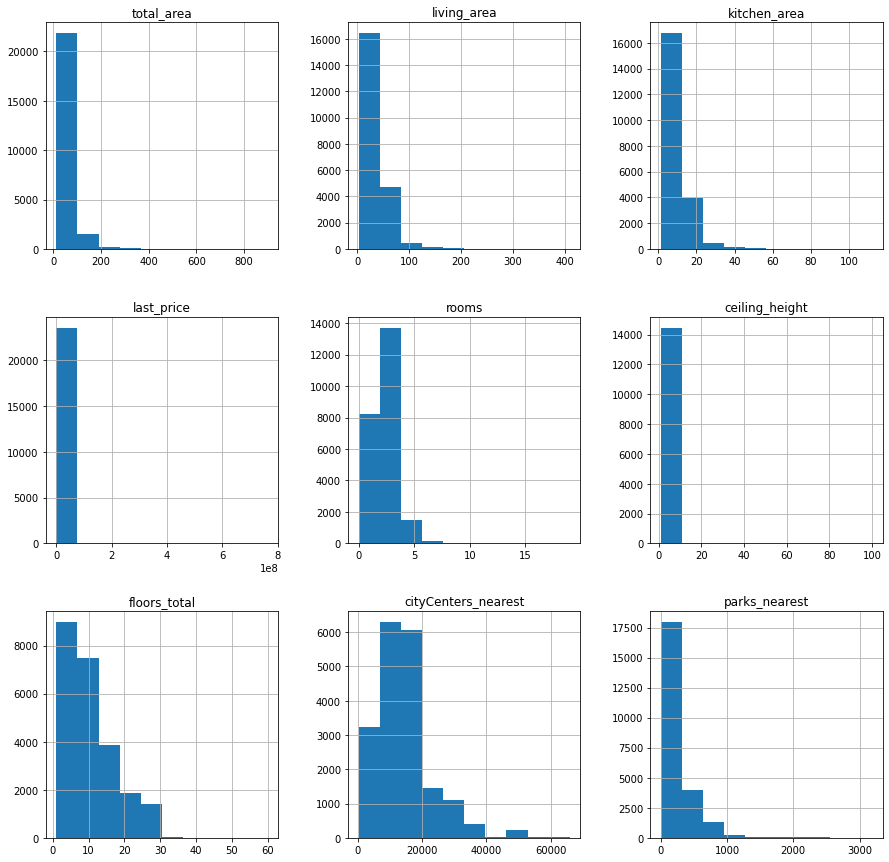

In [26]:
data[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor_category','floors_total', 'cityCenters_nearest', 'parks_nearest']].hist(figsize=(15, 15));

#### Обработка выбросов в столбцах `total_area`, `living_area`, `kitchen_area`. Заполнение пропусков в `living_area`, `kitchen_area`

##### Обработка выбросов в столбцах `total_area`

In [27]:
data.total_area.describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

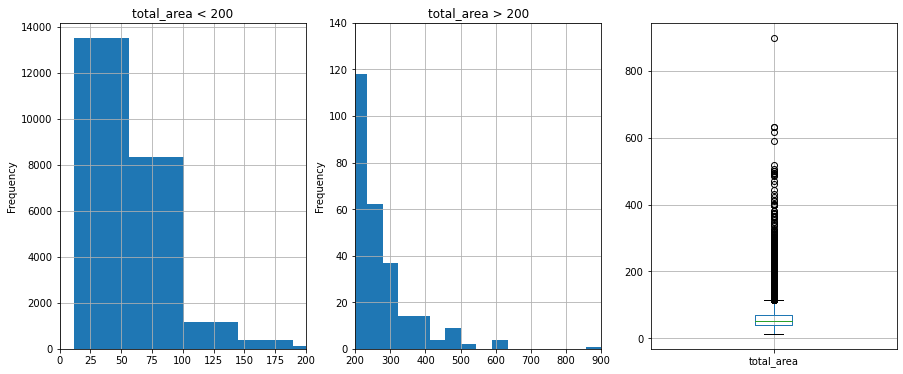

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
data['total_area'].plot(kind = 'hist', xlim = (0,200), bins = 20, grid = True,  title = 'total_area < 200', ax = ax[0])
data['total_area'].plot(kind = 'hist', xlim = (200, 900), ylim = (0, 140), bins = 20,grid = True, title = 'total_area > 200', ax = ax[1])
data.boxplot(column = 'total_area', ax = ax[2])

plt.show()

***Неправдоподобно маленькими выглядят квартиры с общей площадью до 20 кв.м.*** По современным стандартам в однокомнатной квартире площадь жилой комнаты должны быть не менее 14 кв.м, площадь кухни - не менее 5 кв.м. (информация из интернета). Соответственно, общий метраж никак не должен быть менее 20 кв.м. 

Хотя конечно, эти стандарты в прошлом могли быть другими или вообще отсутствовать. *Посмотрим, как много малометражных квартир в нашем датасет.*

Также рассмотрим правый хвост распределения - квартиры метражом свыше 200 кв.м. 

**Если таких немного, удалим их - это не исказит наши выводы.**

In [29]:
print('Количество квартир с площадью до 20 м2:', data.query('total_area < 20').shape[0], ',т.е. доля в датасете -', round(data.query('total_area < 20').shape[0]/ data.shape[0],4))
print ('Количество квартир с площадью от 200 м2:', data.query('total_area >= 200').shape[0], ',т.е. доля в датасете -', round(data.query('total_area >= 200').shape[0]/ data.shape[0],4))


Количество квартир с площадью до 20 м2: 27 ,т.е. доля в датасете - 0.0011
Количество квартир с площадью от 200 м2: 231 ,т.е. доля в датасете - 0.0098


**Удалим эти записи.**

In [30]:
data = data.query('total_area>=20 and total_area<=200')
data.total_area.describe()

count    23396.000000
mean        58.203442
std         26.495794
min         20.000000
25%         40.000000
50%         52.000000
75%         68.900000
max        200.000000
Name: total_area, dtype: float64

##### Обработка выбросов в столбцах  `living_area`, `kitchen_area`

Посмотрим, пропали ли выбросы в столбцах `living_area`, `kitchen_area`. Но сперва проверим, во всех ли яейках общая площыдь больше суммарной  площади кухни и жилой зоны. ***Удалим записи, в которых эта логика нарушена.***

In [31]:
print ('Кол-во записей, для которых total_area < (living_area + kitchen_area):', data.query('total_area < (living_area + kitchen_area) ').shape[0])

Кол-во записей, для которых total_area < (living_area + kitchen_area): 64


In [32]:
# Удаляем эти записи
data = data[~(data['total_area'] < (data['living_area'] + data['kitchen_area']))]

Вернемся к изучению выбросов.

In [33]:
data[['living_area','kitchen_area']].describe()

,living_area,kitchen_area
count,21471.000000,21115.000000
mean,33.236151,10.371845
std,17.363189,5.349781
min,2.000000,1.300000
25%,18.600000,7.000000
50%,30.000000,9.000000
75%,42.000000,11.940000
max,164.700000,93.200000


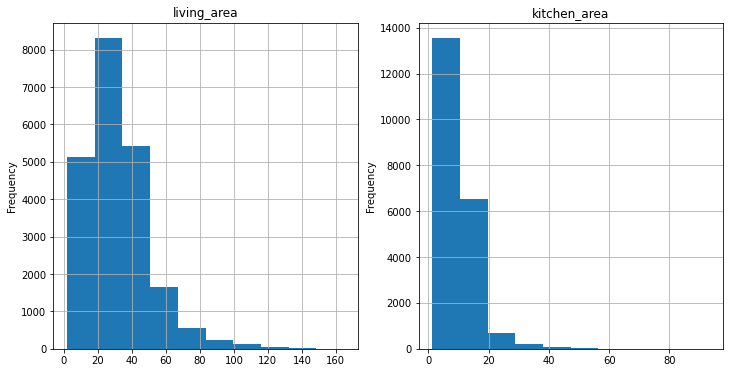

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data['living_area'].plot(kind = 'hist', bins = 10, grid = True,  title = 'living_area', ax = ax[0])
data['kitchen_area'].plot(kind = 'hist', bins = 10,grid = True, title = 'kitchen_area', ax = ax[1])
plt.show()

1) Слишком маленькие метражи жилой зоны и кухни (напр., минимальные значения 2 и 1.3, соответственно) - это странно. Посмотрим, возможно, есть ошибка на порядок, тогда исправим значение на корректное, если нет - удалим эти записи.  *Будем считать, что минимально допустимая площадь жилой зоны - 8 м2, а кухни - 5 м2*

2) Видно, что правые хвосты распределений стали покороче, но все же редкие большие значения все еще встречаются. 

И если в целом, для квартиры площадью 200 м2 (максимально большая квартира, оставшаяся в нашем датасете) площадь жилых комнат 160 м2 выглядит приемлемо, то кухня площадью 90 м2 - это странно. **Добавим в таблицу колонки с отношением жилой площади и площади кухни к общему метражу квартиры, соответственно, и проанализируем выбросы для новых переменных.**

*Также добавим вспомогательный столбец со значениями разности между общей площадью и площадью жилой зоны с кухней.* 

Шаг 1. Слишком маленькие значения living_area, kitchen_area

In [35]:
print('Запсиис с living_area <8:')
display (data.query('living_area <8')[['total_area', 'living_area', 'kitchen_area']])

Запсиис с living_area <8:


,total_area,living_area,kitchen_area
3242,41.0,3.0,11.0
13915,52.0,2.0,9.0
16431,31.0,6.0,17.0
17582,22.0,5.0,NaN
19251,33.0,6.5,18.0
21758,23.0,2.0,NaN
21943,77.6,5.4,9.8
23574,139.0,3.0,16.0


In [36]:
# 2 записи (с индексами строк 3242 и 21943 кажется логичной замена на величину на порядок больше, заменим)
data.loc[3242, 'living_area'] *= 10
data.loc[21943, 'living_area'] *= 10

In [37]:
print('Записис с kitchen_area <5:')
display (data.query('kitchen_area <5')[['total_area', 'living_area', 'kitchen_area']].sort_values(by = 'total_area', ascending = False))

Записис с kitchen_area <5:


,total_area,living_area,kitchen_area
7950,66.40,44.40,2.89
22623,61.00,44.90,4.80
18989,60.65,39.07,4.50
12285,60.20,43.30,4.20
5415,60.00,38.70,4.80
...,...,...,...
22280,22.40,14.50,4.80
18231,22.00,12.00,4.60
7047,21.00,14.90,3.80
6544,20.30,16.00,4.00


С площадью кухни сложнее - во-первых, в область ниже нашего критерия (площадь кухни 5 м2) попадает уже 100 записей, во-вторых, для всеъ этих записей общая площадь квартиры небольшая (максимальная в этой выборке общая плодь - 66.4м2), так что ошибка если и есть, то не в порядке, а в самом значении - не будем пока исправлять, *оставим эти значения как есть.*

Шаг 2. Добавление новых столбцов и изучение аномалий в новых переменных

In [38]:
data['living_to_total_ratio'] = data['living_area']/data['total_area'] # добавляем новый столбец
data['kitchen_to_total_ratio'] = data['kitchen_area']/data['total_area'] # добавляем новый столбец
data['other_area'] = data['total_area'] - data['living_area'].fillna(0) - data['kitchen_area'].fillna(0) # добавляем вспомогательный столбец, если есть значения nan, в расчетах заменяем на 0

Сперва проанализируем выбросы в значениях living_to_total_ratio

In [39]:
display(data.living_to_total_ratio.describe())

count    21471.000000
mean         0.563505
std          0.103798
min          0.021583
25%          0.494505
50%          0.566766
75%          0.636364
max          1.000000
Name: living_to_total_ratio, dtype: float64

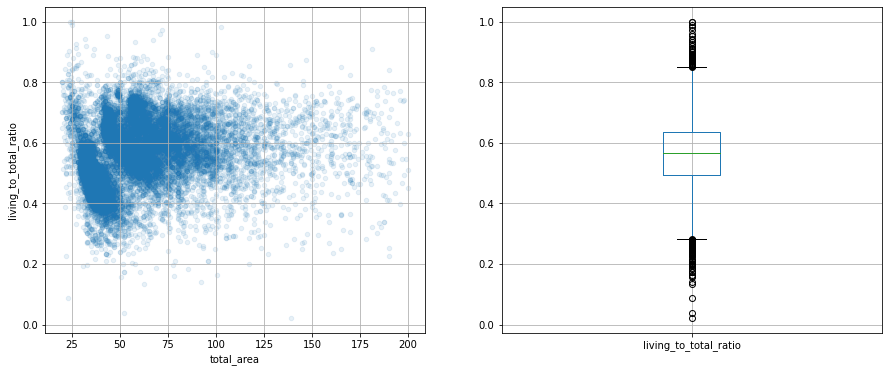

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
data.plot(kind = 'scatter',y = 'living_to_total_ratio', x = 'total_area', grid = True, alpha = .1, ax = ax[0])
data.boxplot(column = 'living_to_total_ratio', ax = ax[1])

plt.show()

Посмотрим на living_to_total_ratio<0.3 и living_to_total_ratio>0.85. По графику boxplot - это пределы интерквартильного размаха. По логике living_to_total_ratio<0.3 - слишком мало, ведь большая часть площади квартиры все же жилая. **Удалим эти значения.**

Большие значения (больше 0.85) могуть быть ок для квартир большой площади, но для малометражных квартир выглядит неправдоподобно с учетом минимальных требований на площадь кухни и наличие санузла. 

Будем считать, что минимальная площадь кухня - 5 м2, и **для области living_to_total_ratio>0.85 удалим те записи, для которых либо kitchen_area <5, либо `other_area` < 7 (с учетом санузла), если kitchen_area - nan. **

In [41]:
print('Кол-во записей с living_to_total_ratio <=0.3')
display(data.query('living_to_total_ratio <=0.3').shape[0])
print('Кол-во записей с living_to_total_ratio > 0.85 and (kitchen_area <5 or (kitchen_area.isna() and other_area <7)):')
display(data.query('living_to_total_ratio > 0.85 and (kitchen_area <5 or (kitchen_area.isna() and other_area <7))').shape[0])

Кол-во записей с living_to_total_ratio <=0.3


189

Кол-во записей с living_to_total_ratio > 0.85 and (kitchen_area <5 or (kitchen_area.isna() and other_area <7)):


25

In [42]:
#удаляем эти записи
data = data[~(data['living_to_total_ratio']<=0.3)]
data = data[~((data['living_to_total_ratio'] > 0.85) & ( (data['kitchen_area']<5) | ( (data['kitchen_area'].isna()) & (data['other_area'] <7)    )   )  )]

Теперь проанализируем выбросы в значениях kitchen_to_total_ratio

In [43]:
display(data.kitchen_to_total_ratio.describe())

count    20933.000000
mean         0.186033
std          0.068751
min          0.025381
25%          0.133630
50%          0.172358
75%          0.230769
max          0.715232
Name: kitchen_to_total_ratio, dtype: float64

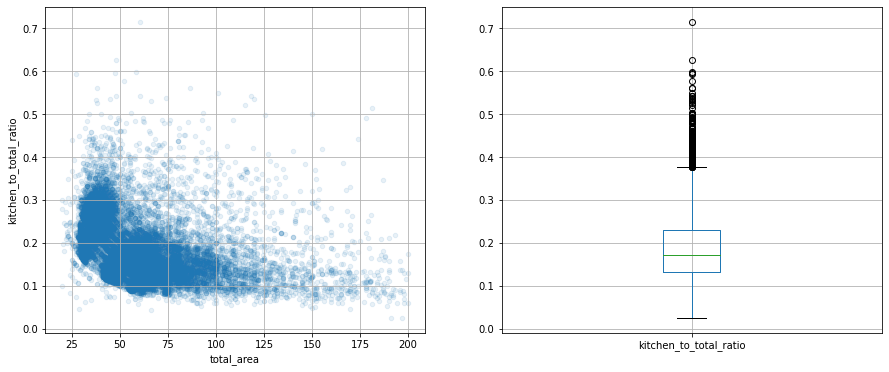

In [44]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

data.plot(kind = 'scatter',y = 'kitchen_to_total_ratio', x = 'total_area', grid = True, alpha = .1, ax = ax[0])
data.boxplot(column = 'kitchen_to_total_ratio', ax = ax[1])

plt.show()

Видно, что у большинства квартир кухня занимает от 10 до 30% общей площади. При этом, чем квартира меньше, тем выше в общей площади доля кухни (что логично).
Квартиры, у которых кухня занимает от 40% всей площади - это выбросы, удалим их.

In [45]:
print('Коли-во записей к удалению (с kitchen_to_total_ratio >= 0.4) :')
display(data[data['kitchen_to_total_ratio'] >=0.4].shape[0])
data = data[~(data['kitchen_to_total_ratio'] >=0.4)] #удаляем эти записи

Коли-во записей к удалению (с kitchen_to_total_ratio >= 0.4) :


180

##### Заполнение пропусков в `living_area`, `kitchen_area`

Теперь, когда данные в `total_area`, `living_area`, `kitchen_area` очищены, можем заполнить пропуски в столбцах `living_area`, `kitchen_area`. Пропуски будем заполнять на основании медианных значений `living_to_total_ratio` и `kitchen_to_total_ratio`. 

Как мы видели, у `living_to_total_ratio` и `kitchen_to_total_ratio` есть зависимость от `total_area`, поэтому порядок действий такой:
- снова построим диаграммы рассеяния `living_to_total_ratio` и `kitchen_to_total_ratio` от `total_area`, 
- выделим группы, и для каждой группы определим медианное значение
- ***пропуски будем заполнять на основании рассчитанных медиан в зависимости от значения `total_area`.***

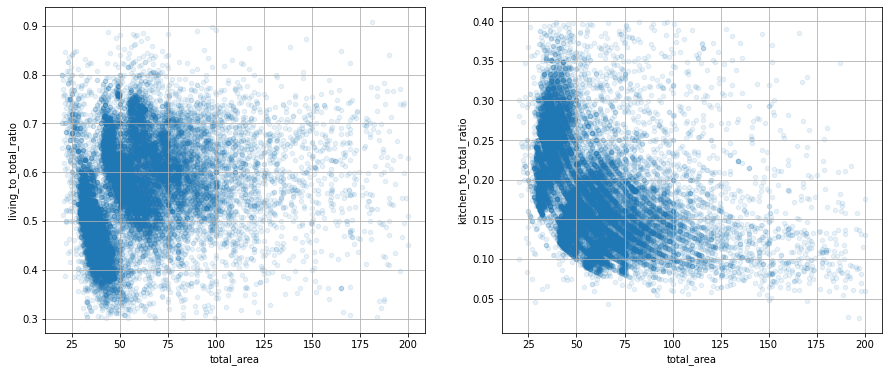

In [46]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

data.plot(kind = 'scatter',y = 'living_to_total_ratio', x = 'total_area', grid = True, alpha = .1, ax = ax[0])
data.plot(kind = 'scatter',y = 'kitchen_to_total_ratio', x = 'total_area', grid = True, alpha = .1, ax = ax[1])

plt.show()

Определим критерии для группировки так:
- total_area <= 50
- 50 <total_area< 100
- total_area >= 100

In [47]:
#создаем таблицу с медиананными значениями living_to_total_ratio и kitchen_to_total_ratio в зависимости от общей площади
area_median = pd.DataFrame (data = [data.query('total_area<=50')[['living_to_total_ratio','kitchen_to_total_ratio']].median(),\
                     data.query('total_area>50 and total_area< 100')[['living_to_total_ratio','kitchen_to_total_ratio']].median(),\
                     data.query('total_area>= 100')[['living_to_total_ratio','kitchen_to_total_ratio']].median()],\
                     index = ['total_area <=50', 'total_area 50-100', 'total_area >=100'])
area_median

,living_to_total_ratio,kitchen_to_total_ratio
total_area <=50,0.528775,0.216216
total_area 50-100,0.594340,0.150943
total_area >=100,0.592756,0.130332


In [48]:
# проходим циклом по всем пропускам в living_area и заполняем их
for index, row in data.query('living_area.isna()').iterrows():
    try:
        if data.loc[index,'total_area'] <= 50:
            data.loc[index, 'living_area'] = data.loc[index,'total_area']*area_median.iloc[0,0]
        elif data.loc[index, 'total_area']<100:
            data.loc[index, 'living_area'] = data.loc[index,'total_area']*area_median.iloc[1,0]
        elif data.loc[index, 'total_area'] >=100:
            data.loc[index, 'living_area'] = data.loc[index,'total_area']*area_median.iloc[2,0]
    except:
        pass
            

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [49]:
print("Кол-во пропусков в столбце living_area после заполнения:", data.query('living_area.isna()').shape[0])

Кол-во пропусков в столбце living_area после заполнения: 0


In [50]:
# проходим циклом по всем пропускам в kitchen_area и заполняем их
for index, row in data.query('kitchen_area.isna()').iterrows():
    try:
        if data.loc[index,'total_area'] <= 50:
            data.loc[index, 'kitchen_area'] = data.loc[index,'total_area']*area_median.iloc[0,1]
        elif data.loc[index, 'total_area']<100:
            data.loc[index, 'kitchen_area'] = data.loc[index,'total_area']*area_median.iloc[1,1]
        elif data.loc[index, 'total_area'] >=100:
            data.loc[index, 'kitchen_area'] = data.loc[index,'total_area']*area_median.iloc[2,1]
    except:
        pass
            

In [51]:
print("Кол-во пропусков в столбце kitchen_area после заполнения:", data.query('kitchen_area.isna()').shape[0])

Кол-во пропусков в столбце kitchen_area после заполнения: 0


#### Обработка выбросов в столбце `last_price`

In [52]:
data.last_price.describe()

count    2.293800e+04
mean     5.980030e+06
std      6.103781e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.650000e+06
max      3.300000e+08
Name: last_price, dtype: float64

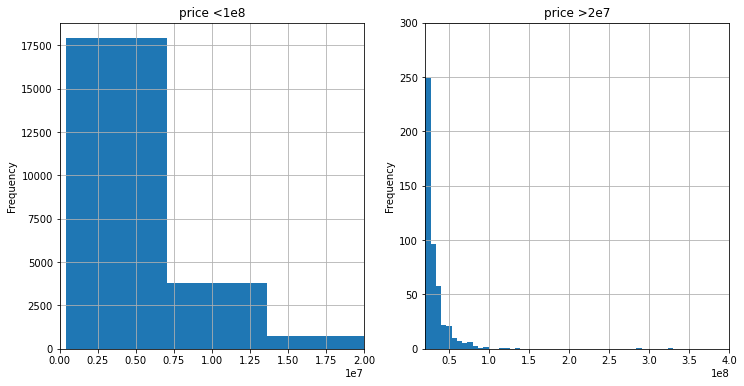

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data['last_price'].plot(kind = 'hist', xlim = (0,0.2e8), bins = 50, grid = True,  title = 'price <1e8', ax = ax[0])
data['last_price'].plot(kind = 'hist', xlim = (0.2e8, 4e8), ylim = (0, 300), bins = 50,grid = True, title = 'price >2e7', ax = ax[1])
plt.show()

Порядок стоимотсти квартиры - миллионы рублей. Однако есть несколько квартир с ценами > 50млн. и есть квартиры с ценой меньше полумиллиона. Возможно, высокая цена связана с большим метражом, а низкая цена соответствует маленькой площади квартиры, и цены являются разумными. Тогда логичнее смотреть не на абсолютную величину цены за квартиру, а на значения цены в расчете на 1 м2.

In [54]:
display(data.m_price.describe())

count    2.293800e+04
mean     9.781511e+04
std      4.466254e+04
min      7.962960e+03
25%      7.619048e+04
50%      9.456522e+04
75%      1.133333e+05
max      1.736842e+06
Name: m_price, dtype: float64

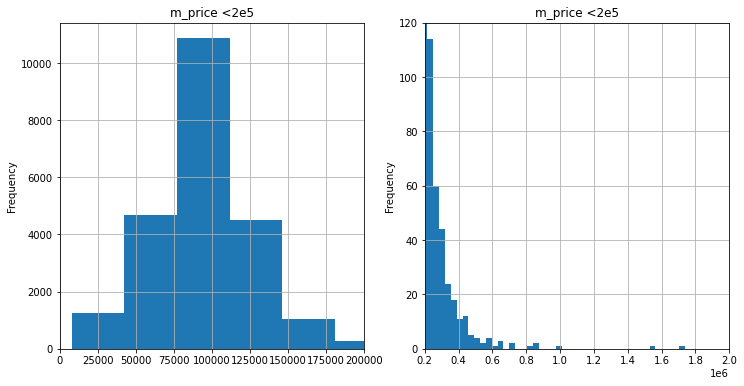

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data['m_price'].plot(kind = 'hist',  xlim = (0, 2e5), bins = 50, grid = True,  title = 'm_price <2e5', ax = ax[0])
data['m_price'].plot(kind = 'hist', xlim = (2e5, 2e6), ylim = (0, 120), bins = 50,grid = True, title = 'm_price <2e5', ax = ax[1])
plt.show()

В основном цена за м2 лежит в диапазоне от 70 до 110 тыс. Логично предположить, что очень низкие значения (с ценой до 20тыс за м2) - это квартиры в маленьких населенных пунктах, где рыночные цены на недвижимость ниже, а очень высокие цены за м2 - это  квартиры в историческом центре Петербурга.

***Объявления с очень низкими и очень высокими ценами за м2, которые не укладываются в это предположение, удалим из датасета.***

In [56]:
#изучим, какие медианные цены за м2 в тех населенных пунктах, в которых есть объявления о продаже с ценами ниже 20000 за м2

# названия населенных пункутов, в которых низкие цены за м2
low_price_locations = data.loc[data["m_price"]<20000, "locality_name"].values 
# медианные цены за м2 в этих населенных пунктах в порядке возрастания цены
median_m_prices = data.query('locality_name in @low_price_locations').pivot_table (index = 'locality_name', values = 'm_price', aggfunc = 'median').sort_values(by = 'm_price').reset_index()
median_m_prices


,locality_name,m_price
0,Старополье,11000.000
1,Свирь,11481.480
2,Вахнова Кара,11688.310
3,Выскатка,12335.480
4,Совхозный,12629.130
5,Малая Романовка,12724.550
6,Тесово-4,12931.030
7,Сижно,13709.680
8,Ям-Тесово,13711.555
9,Житково,14956.275


In [57]:
#обновим список локаций с низкими ценами: в списке будут локации, у которых есть объявления с ценами <20000 за м2, при том что рыночная цена в этом населенном пункте выше 20000
low_prices_locations = median_m_prices.query('m_price>20000')['locality_name'].values
#удалим записи, у которых цена за м2 ниже 20 тыс и локация в списке low_prices_locations
data =data[~((data.m_price < 20000) & (data['locality_name'].isin(low_prices_locations)))]


Выберем критерием близости к центру значение cityCenters_nearest< 5000 (помним, что в распределении этажности домов от удаленности от центра, было видно, что район 4-5 км от центра застроен невысокими домами, определили эту зону как исторический центр).

*Посмотрим, сколько квартир находятся на удалении от центра, при этом имеют высокую стоимость (свыше 300 тыс за м2 ).* ***Если таких записей не очень много, удалим их из датасета***

In [58]:
data.query('m_price > 300000 and cityCenters_nearest>5000')[['locality_name',  'cityCenters_nearest']].sort_values(by =['locality_name', 'cityCenters_nearest'])

,locality_name,cityCenters_nearest
15037,Зеленогорск,51115.0
12872,Санкт-Петербург,5065.0
2123,Санкт-Петербург,5249.0
5286,Санкт-Петербург,5297.0
16590,Санкт-Петербург,5297.0
...,...,...
22635,Санкт-Петербург,10364.0
14496,Санкт-Петербург,10720.0
14944,Санкт-Петербург,12244.5
16247,Санкт-Петербург,12244.5


In [59]:
#удалим записи, у которых цена за м2 выше 300 тыс и находящиеся >5км от центра
data = data[~( (data.m_price > 300000) & (data.cityCenters_nearest>5000) )]

#### Обработка выбросов в столбце `rooms`

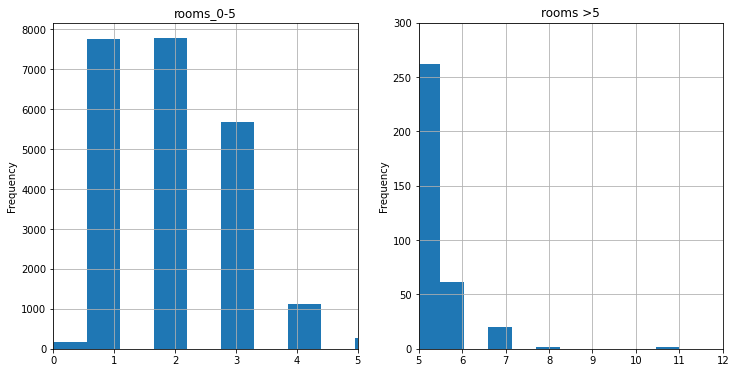

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data['rooms'].plot(kind = 'hist', xlim = (0,5), bins = 20, grid = True,  title = 'rooms_0-5', ax = ax[0])
data['rooms'].plot(kind = 'hist', xlim = (5, 12), ylim = (0, 300), bins = 20,grid = True, title = 'rooms >5', ax = ax[1])
plt.show()
 

В основном продают квартиры с 1-3 комнатами. 
- квартир с 6+ комнатами мало, ***удалим эти записи***
- в выгрузке есть квартиры с кол-вом комнат 0, *вероятно, продавец не указал кол-во комнат в объявлении.* ***Заменим нули на моду кол-ва комнат в похожих по площади квартирах.***

In [61]:
#удалим записи с числом комнат 6+
data = data[~(data.rooms>5)]

In [62]:
print ("Кол-во нулевых значений в столбце rooms: ", (data.rooms == 0).sum())

Кол-во нулевых значений в столбце rooms:  176


<AxesSubplot:xlabel='total_area', ylabel='rooms'>

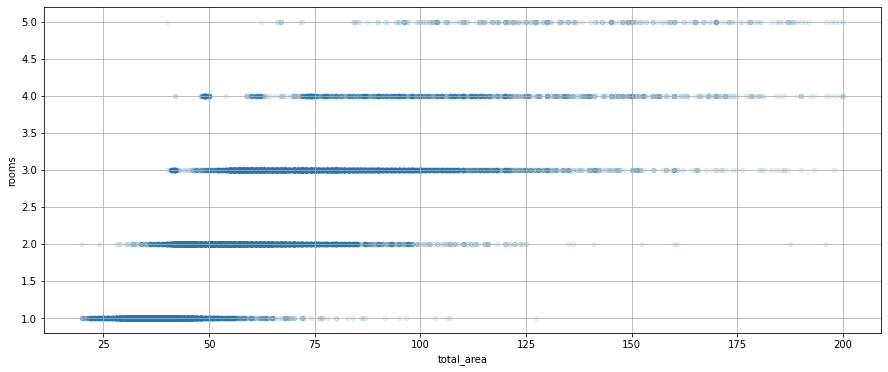

In [63]:
data.query('rooms >0 ').plot(kind = 'scatter', x = 'total_area', y = 'rooms', figsize = (15,6), alpha = .1, grid = True)

- <50 m2
- 50 - 80
- 80 - 110
- 110 - 150
- '>150


In [64]:
#создаем таблицу со значениями моды кол-ва комнат в зависимости от общей площади
rooms_mod = pd.DataFrame (data = [data.query('total_area<=50')['rooms'].mode(),\
                     data.query('total_area>50 and total_area<= 80')['rooms'].mode(),\
                     data.query('total_area>80 and total_area<= 110')['rooms'].mode(),\
                     data.query('total_area>110 and total_area<= 150')['rooms'].mode(),\
                     data.query('total_area>150')['rooms'].mode()],\
                     index = ['total_area <=50', 'total_area 50-80', 'total_area 80-110', 'total_area 110-150', 'total_area >150'])
rooms_mod

,0
total_area <=50,1
total_area 50-80,2
total_area 80-110,3
total_area 110-150,3
total_area >150,4


In [65]:
# проходим циклом по всем нулевым значениям в rooms и заменяем их модой в зависимсоти от total_area
for index, row in data.query('rooms == 0').iterrows():
    try:
        if data.loc[index,'total_area'] <= 50:
            data.loc[index, 'rooms'] = rooms_mod.iloc[0].values[0]
        elif data.loc[index, 'total_area']<80:
            data.loc[index, 'rooms'] = rooms_mod.iloc[1].values[0]
        elif data.loc[index, 'total_area']<150:
            data.loc[index, 'rooms'] = rooms_mod.iloc[2].values[0]
        elif data.loc[index, 'total_area'] >150:
            data.loc[index, 'rooms'] = rooms_mod.iloc[4].values[0]
    except:
        pass

In [66]:
data.query('rooms == 0').shape[0]

0

#### Обработка выбросов и заполнение пропусков в столбце `ceiling_height`

##### Обработка выбросов в столбце `ceiling_height`

In [67]:
display(data['ceiling_height'].describe())

count    13955.000000
mean         2.748953
std          0.935986
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

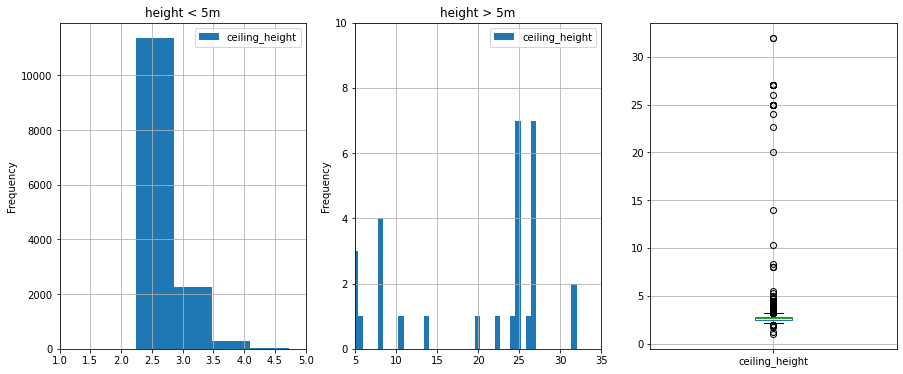

In [68]:
fig, ax = plt.subplots (1, 3, figsize = (15,6))

data.plot(kind = 'hist', y = 'ceiling_height', bins = 50,  xlim = (1, 5), grid = True, ax = ax[0], title = 'height < 5m')
data.plot(kind = 'hist', y = 'ceiling_height', bins = 50,  xlim = (5, 35), ylim = (0, 10), grid = True, ax = ax[1], title = 'height > 5m')
data.boxplot(column = 'ceiling_height', ax = ax[2])
plt.show()

Больше всего в нашем датасете квартир с высотой потолков от 2.5 до 3 м. По графику боксплот видно, что разброс значений очень большой.
- Согласно нормам строительства высота потолков не может быть меньше 2.5 м (информация из интернета). Предположим, что пользователи могли указывать фактическую высоту потолков при наличии, например, натяжных потолков, которые "съедают" 5-10 см. ***Удалим записи с высотой потолков <2.4 м***
- Квартиры с высотой потолков от 10м - выглядят неправдоподобно, скорее всего есть ошибка в порядке, ***скорректируем эти значения, поделив на 10.***

In [69]:
#делим на 10
data.loc[data['ceiling_height'] >= 10, 'ceiling_height']  /= 10
print ('Кол-во записей с ceiling_height >=10 после обработки:' , data.loc[data['ceiling_height'] > 10, 'ceiling_height'].count() )

Кол-во записей с ceiling_height >=10 после обработки: 0


In [70]:
#убираем неправдоподобно низкие потолки
data = data[~(data.ceiling_height <2.4)]
print ('Кол-во записей с ceiling_height <2.4 после обработки:' , data.query('ceiling_height <2.4').shape[0])

Кол-во записей с ceiling_height <2.4 после обработки: 0


##### Заполнение пропусков в столбце `ceiling_height`

In [71]:
data.ceiling_height.isna().sum() #кол-во пропусков в ceiling_height

8811

<AxesSubplot:>

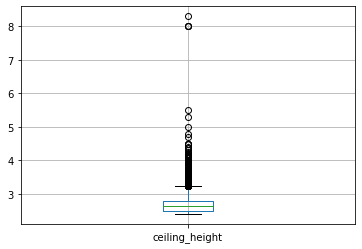

In [72]:
#график boxplot после обработки
data.boxplot(column = 'ceiling_height')

Можно предположить, что высокие потолки - это преимущественно старый жилищный фонд, т.е. малоэтажные здания (и, вероятнее всего, центральные районы Петербурга). ***Проверим гипотезу о зависимости высоты потолков и этажности здания с помощью соответствующей диаграммы рассеяния.***

<AxesSubplot:xlabel='floors_total', ylabel='ceiling_height'>

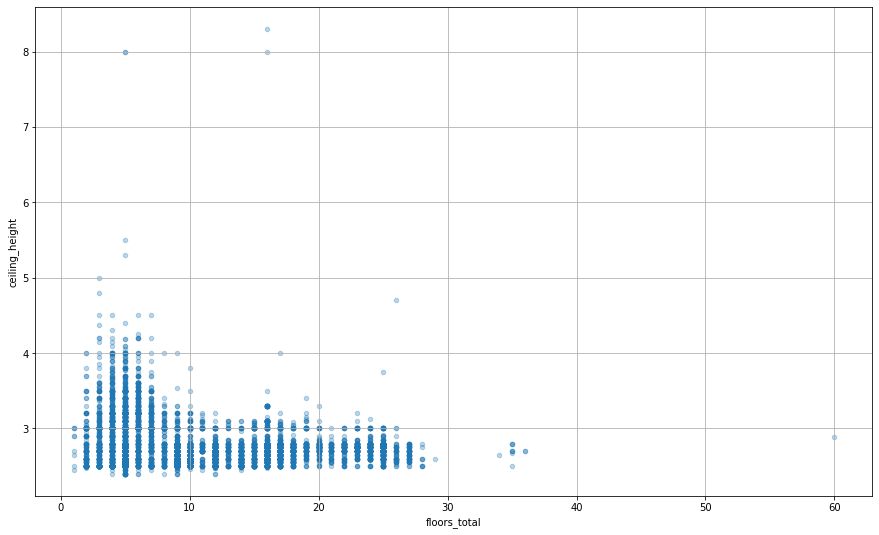

In [73]:
data.plot(kind = 'scatter', x = 'floors_total', y = 'ceiling_height', alpha = .3, figsize = (15,9), grid = True)

Видно, что действительно высокие потолки значительно чаще встречаются в малоэтажных домах. 

*Теперь проверим, в каких населенных пунктах и на какой удаленности от центра, чаще всего встрачаются квартиры с потолками выше 3м. Наша гипотеза - больше всего квартир в Санкт-Петербурге на небольшом удалении от центра*

In [74]:
print('Кол-во квартир с полтолками выше 3м:', data.query('ceiling_height>3 ').shape[0])
print('Из них квартир в Санкт-Петербурге:',data.query('ceiling_height>3 and locality_name == "Санкт-Петербург"').shape[0])

Кол-во квартир с полтолками выше 3м: 1282
Из них квартир в Санкт-Петербурге: 1173


<AxesSubplot:xlabel='cityCenters_nearest', ylabel='ceiling_height'>

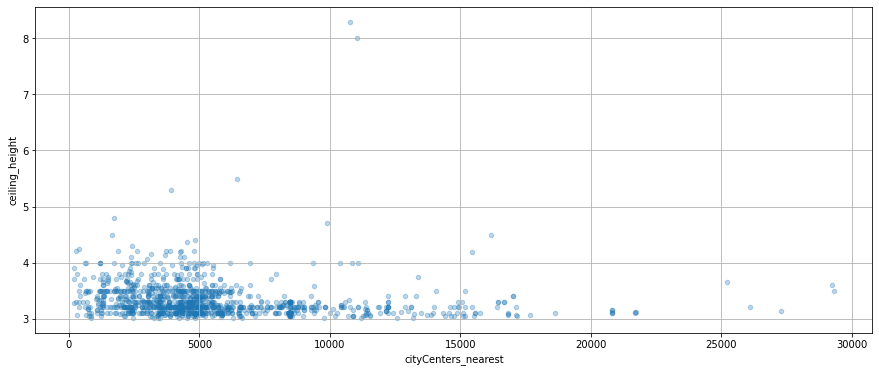

In [75]:
data.query('ceiling_height>3 and locality_name == "Санкт-Петербург"').plot(kind = 'scatter', x = 'cityCenters_nearest', y = 'ceiling_height', alpha = .3, figsize = (15,6), grid = True)

Наша гипотеза подтверждается - *большое кол-во квартир с высокими потолками расположено в СПБ на расстоянии до 6 км от центра.*

***Поэтому посчитаем отдельно 2 медианы: для квартир в центре СПБ (расстояние до центра до 6 км) и медиана для всех остальных квартир. Пропуски заменим соответстующей медианной.***

In [76]:
height_median = pd.Series([data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest<= 6000')['ceiling_height'].median(),\
                           data[~((data.locality_name == "Санкт-Петербург") & (data.cityCenters_nearest<= 6000))]['ceiling_height'].median()],\
                           index = ['SPB_center', 'other'])
height_median

SPB_center    3.01
other         2.60
dtype: float64

In [77]:
data.query('ceiling_height.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m_price,wday_exposition,month_exposition,year_exposition,floor_category,cityCenters_nearest_km,living_to_total_ratio,kitchen_to_total_ratio,other_area
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.600000,1,False,False,False,11.000000,2,Шушары,12817.0,18603.0,0,0.0,0,0.0,81.0,82920.79,1,12,2018,первый,19.0,0.460396,0.272277,10.80
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0,0.612500,0.148214,13.40
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.400000,5,False,False,False,9.100000,0,Янино-1,NaN,NaN,0,0.0,0,0.0,55.0,95065.79,0,9,2018,другой,NaN,0.473684,0.299342,6.90
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,42.554717,22,False,False,False,18.900000,2,Санкт-Петербург,23982.0,11634.0,0,0.0,0,0.0,NaN,110544.69,3,4,2019,другой,12.0,NaN,0.263966,52.70
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.430000,26,False,False,False,8.810000,0,Мурино,51553.0,21888.0,0,0.0,0,0.0,189.0,87454.76,2,5,2018,другой,22.0,0.465320,0.265682,8.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000.0,39.00,2017-12-16,1,NaN,9,20.000000,6,False,False,False,11.000000,2,Санкт-Петербург,40837.0,16704.0,0,0.0,0,0.0,38.0,82051.28,5,12,2017,другой,17.0,0.512821,0.282051,8.00
23690,3,5500000.0,52.00,2018-07-19,2,NaN,5,31.000000,2,False,False,False,6.000000,0,Санкт-Петербург,20151.0,6263.0,1,300.0,0,0.0,15.0,105769.23,3,7,2018,другой,6.0,0.596154,0.115385,15.00
23692,2,1350000.0,30.00,2017-07-07,1,NaN,5,17.500000,4,False,False,False,6.000000,0,Тихвин,NaN,NaN,0,0.0,0,0.0,413.0,45000.00,4,7,2017,другой,NaN,0.583333,0.200000,6.50
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.000000,4,False,False,False,8.500000,0,Тосно,NaN,NaN,0,0.0,0,0.0,45.0,52542.37,0,1,2018,другой,NaN,0.644068,0.144068,12.50


In [78]:
for index, row in data.query('ceiling_height.isna()').iterrows():
    try:
        if ((data.loc[index, 'locality_name'] == 'Санкт-Петербург') and (data.loc[index, 'cityCenters_nearest'] <= 6000) ):
            data.loc[index, 'ceiling_height'] = height_median[0]
        else:
            data.loc[index, 'ceiling_height'] = height_median[1]
    except:
        pass

In [79]:
print('Кол-во пропусков ceiling_height после обработки:' , data.query('ceiling_height.isna()').shape[0])

Кол-во пропусков ceiling_height после обработки: 0


#### Изучение параметров `floor_category`, `floors_total`

In [80]:
data.floors_total.describe()

count    22741.000000
mean        10.714349
std          6.584844
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

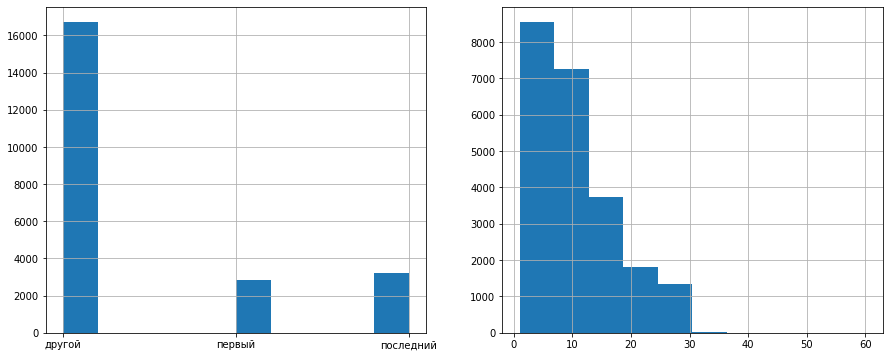

In [81]:
figsize, ax = plt.subplots(1,2, figsize = (15,6))

data.floor_category.hist(ax = ax[0])
data.floors_total.hist(ax = ax[1])

plt.show()

В датасете присутствует примерно по 3000 записей с квартирами на первом и последнем этажах, а остальные почти 17000 записей - это квартиры на других этажах (не первый и не последний). 

По распределению кол-ва этажей:
- странным кажется квартиры в домах с одним этажом (может, это не квартира, а частный дом?). Посмотрим, сколько таких и где они расположены. Примем решение об удалении этих записей
- квартира в 60-этажном - скорее всего, ошибка. Также посмотрим, где находится, и также удалим, если это действительно ошибка
- больше всего квартир в домах до 16 этажей

In [82]:
data.query('floors_total == 1')['locality_name'].value_counts()

Рощино             2
Санкт-Петербург    2
Сестрорецк         2
Суйда              1
Ефимовский         1
Сосново            1
Свирьстрой         1
Зеленогорск        1
Волосово           1
Луга               1
Гаврилово          1
Каськово           1
Вещево             1
Большие Колпаны    1
Стрельна           1
Большая Ижора      1
Пчевжа             1
Оредеж             1
Сижно              1
Name: locality_name, dtype: int64

In [83]:
data.query('floors_total == 60')['locality_name']

2253    Кронштадт
Name: locality_name, dtype: object

Удалим записи с общим кол-вом этажей в доме, равным 1 и 60.

In [84]:
data = data[~((data.floors_total == 1) | (data.floors_total == 60))]

#### Изучение параметров `cityCenters_nearest`, `parks_nearest`

In [85]:
display(data.cityCenters_nearest.describe())
display(data.parks_nearest.describe())

count    18015.00000
mean     14655.84388
std       8568.29753
min        181.00000
25%       9873.00000
50%      13370.00000
75%      16804.00000
max      65968.00000
Name: cityCenters_nearest, dtype: float64

count    22718.000000
mean       165.345629
std        305.661650
min          0.000000
25%          0.000000
50%          0.000000
75%        293.000000
max       3190.000000
Name: parks_nearest, dtype: float64

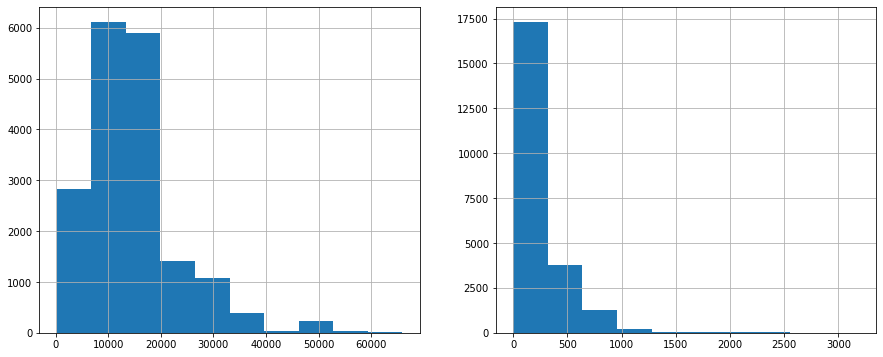

In [86]:
figsize, ax = plt.subplots(1,2, figsize = (15,6))

data.cityCenters_nearest.hist(ax = ax[0])
data.parks_nearest.hist(ax = ax[1])

plt.show()

- Большинство квартир имеют парки на расстоянии до 1 км от дома
- Большинство квартира в нашем датасете находится на расстоянии до 30 км от центра, но есть некоторое кол-во квартир (около 300) с расстоянием до центра - от 40 до 60 км, выглядит несколько странно, посмотрим на эти данные повнимательнее.

In [87]:
#в каких городах квартиры на расстоянии 40+ км от центра и сколько таких записей 
data.query('cityCenters_nearest > 40000')['locality_name'].value_counts()

Ломоносов       124
Кронштадт        95
Петергоф         38
Зеленогорск      22
Красное Село      8
Молодежное        5
Репино            4
Сестрорецк        1
Name: locality_name, dtype: int64

In [88]:
#в цикле посмотрим, 40+ км - это ошибка, или типичное значение для квартир в данном населенном пункте
for el in data.query('cityCenters_nearest > 40000')['locality_name'].unique():
    print( el, data.query('locality_name == @el ')['cityCenters_nearest'].describe())

Ломоносов count      133.000000
mean     50747.015038
std       3989.180139
min      36816.000000
25%      50752.000000
50%      51677.000000
75%      52136.000000
max      61495.000000
Name: cityCenters_nearest, dtype: float64
Кронштадт count       95.000000
mean     49196.642105
std       1647.675596
min      46657.000000
25%      47163.000000
50%      49575.000000
75%      50598.500000
max      51511.000000
Name: cityCenters_nearest, dtype: float64
Петергоф count      199.000000
mean     35490.512563
std       5708.209259
min      29815.000000
25%      31532.000000
50%      33771.000000
75%      35511.000000
max      49574.000000
Name: cityCenters_nearest, dtype: float64
Зеленогорск count       22.000000
mean     54795.136364
std       3243.429392
min      51115.000000
25%      52779.750000
50%      53381.000000
75%      54856.000000
max      62706.000000
Name: cityCenters_nearest, dtype: float64
Молодежное count        5.0000
mean     65529.2000
std        514.3527
min      64857.0

Как подсказывает Гугл, все эти населенные пункты являются внутригородскими муниципальными образованиями, входящими в Санкт-Петербург. Поэтому расстояние, вероятно, определяется до центра СПБ.

#### Изучение параметра `days_exposition`

##### Изучение параметра `days_exposition` 

<AxesSubplot:ylabel='Frequency'>

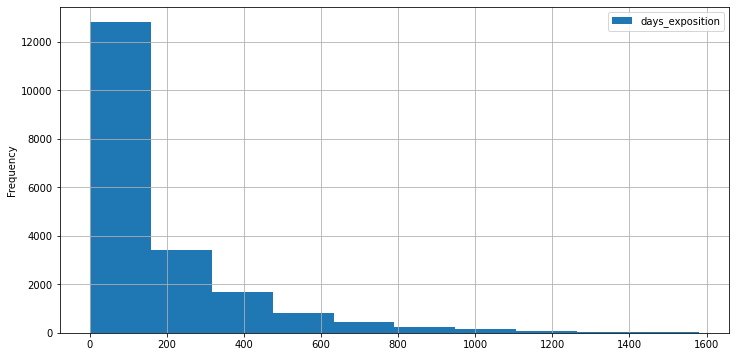

In [89]:
data.plot(kind = 'hist', y = 'days_exposition', figsize = (12,6), grid = True)

In [90]:
data['days_exposition'].describe(percentiles=[.25, .5, .75, .9])

count    19707.000000
mean       179.275334
std        218.213392
min          1.000000
25%         45.000000
50%         94.000000
75%        229.000000
90%        453.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее значение величины days_exposition - 179 дней, а медиана - 94 дня. *Такая большая разница между медианой и среднем свидетельствует о том, что в выборке есть очень большие значения , которые искажают среднее.* Это видно и в описательной статистике: 90% всех наблюдений имеет days_exposure <450 дней, при этом максимальное значение - 1580. 

<AxesSubplot:xlabel='year_exposition', ylabel='days_exposition'>

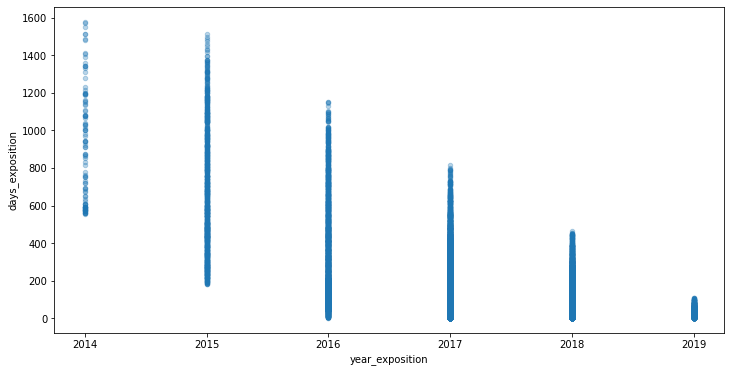

In [91]:
data.plot(kind = 'scatter', x = 'year_exposition', y = 'days_exposition', alpha = .3, figsize = (12,6)) 

Если смотреть на параметр days_exposition в зависимости от года публикации объявления (year_exposition), видно, что в 2014 и 2015 годах (кризисные годы) квартиры продавались дольше, с 2016 заметен тренд на снижение срока продажи квартир.

*При этом помним, что наша выгрузка содержит объявления с конца 2014 и по май 2019 года, т.е. не за целый 2014 и 2019.*

In [92]:
#подсчитаем, сколько объявлений публикавалось в каждом году
data[['year_exposition', 'days_exposition']].groupby('year_exposition').count()

,days_exposition
year_exposition,
2014,109
2015,1044
2016,2592
2017,7616
2018,7298
2019,1048


In [93]:
#удостоверимся, что разница между средним и медианой не так велика, если смотреть на параметр days_exposition в разрезе годов публикации 
for el in data.year_exposition.unique():
    print('Year ', el, '\n', data.loc[data.year_exposition == el, 'days_exposition'].describe())
    

Year  2019 
 count    1048.000000
mean       30.842557
std        23.813728
min         1.000000
25%        12.000000
50%        23.000000
75%        45.000000
max       110.000000
Name: days_exposition, dtype: float64
Year  2018 
 count    7298.000000
mean       93.914497
std        84.915794
min         3.000000
25%        34.000000
50%        63.000000
75%       130.000000
max       465.000000
Name: days_exposition, dtype: float64
Year  2015 
 count    1044.000000
mean      648.335249
std       319.082368
min       182.000000
25%       388.000000
50%       578.000000
75%       884.500000
max      1512.000000
Name: days_exposition, dtype: float64
Year  2017 
 count    7616.000000
mean      158.186450
std       152.484566
min         3.000000
25%        45.000000
50%       102.000000
75%       225.000000
max       814.000000
Name: days_exposition, dtype: float64
Year  2016 
 count    2592.000000
mean      321.519290
std       256.359768
min         3.000000
25%       115.000000
50%   

Теперь посмотрим, как внутри года изменялось значения пар-ра days_exposition в зависимости от месяца.

In [94]:
days_exp_median = pd.DataFrame (index = range(1,13), columns = range(2014,2020))

for m in range(1,13):
    for y in range (2014, 2020):
        try:
            days_exp_median.loc[m,y] = data.query('month_exposition == @m and year_exposition == @y')['days_exposition'].median()
        except:
            pass
days_exp_median

,2014,2015,2016,2017,2018,2019
1,NaN,720.5,283.0,182.0,74.0,45.0
2,NaN,903.5,229.0,137.0,74.0,38.0
3,NaN,907.0,211.0,331.0,76.0,19.0
4,NaN,584.0,169.0,130.0,115.5,9.0
5,NaN,599.5,119.0,113.0,156.0,1.0
6,NaN,580.0,110.0,122.0,86.5,NaN
7,NaN,576.5,382.0,114.0,66.0,NaN
8,NaN,507.5,467.0,101.0,60.0,NaN
9,NaN,823.0,449.0,102.0,57.0,NaN
10,NaN,401.0,468.5,98.0,50.0,NaN


<AxesSubplot:>

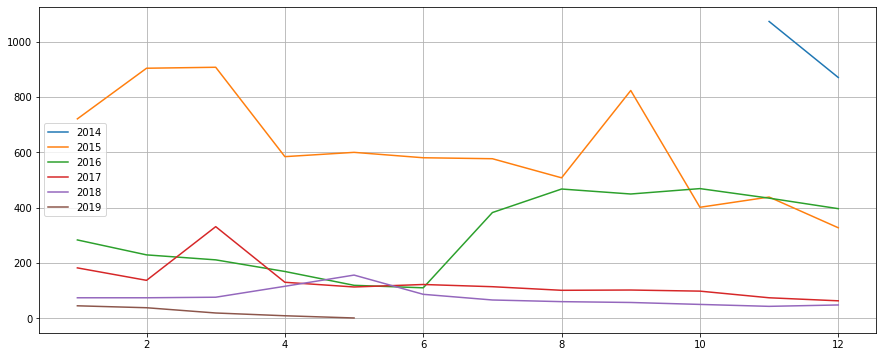

In [95]:
days_exp_median.plot.line(figsize = (15,6), grid = True)

Посмотрим, как изменяется значение пар-ра days_exposition в зависимости от дня недели, когда было опубликовано объявление.

<AxesSubplot:xlabel='wday_exposition'>

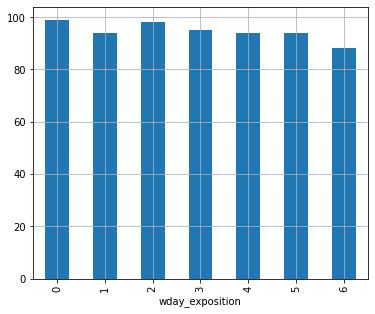

In [96]:
data.groupby('wday_exposition')['days_exposition'].median().plot.bar(grid=True, figsize = (6,5))

Сильных отличий пар-рв days_exposition для объявлений, опубликованных в разные дни неделеи, нет.

#### Исследование зависимости цены от параметров

Изучите, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

##### Исследование зависимости цены от  `total_area`, `living_area`, `kitchen_area`

- Очевидно, цена квартиры должна сильно коррелировать с площадью квартиры: чем площадь больше, тем выше должна быть цена.
- Также очевидно, что это не должна быть прямая пропорциональность, т.к. наиболее ликидные квартиры имеют небольшую площадь, следовательно, у квартир поменьше стоимость квадратного метра должна быть выше.
- Также ясно, что цена квартиры не определяется однозначно только площадью, а зависит также от многих других пар-ров.

Убедимся, что наши соображения верны, с помощью графика зависимости цены от площади, а также посчитаем коэффициент корреляции Пирсона.

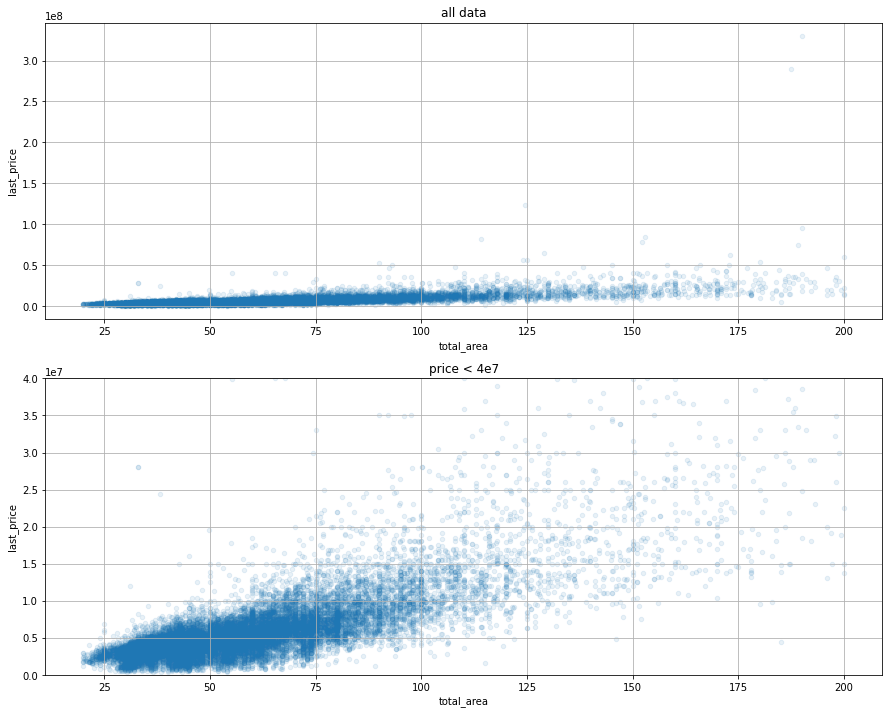

In [97]:
fig, ax = plt.subplots(2,1, figsize = (15, 12))
data.plot(kind = 'scatter', x = 'total_area', y = 'last_price', grid = True, alpha = .1, ax = ax[0], title = 'all data')
data.plot(kind = 'scatter', x = 'total_area', y = 'last_price', grid = True, ylim = (0,4e7), alpha = .1, ax = ax[1], title = 'price < 4e7')
plt.show()

In [98]:
print ('Коэффициент корреляции цены и общей площади:', data['total_area'].corr(data['last_price']))

Коэффициент корреляции цены и общей площади: 0.6654688269078344


На грфике видно, что цена квартиры растет с ростом площади. Коэффициент корреляции 0.66 говорит, что зависимость есть, но не сильная (на цену влияют также другие факторы).

Далее рассмотрим зависимость цены от площади жилой зоны и кухни.

In [99]:
print ('Коэффициент корреляции цены и жилой площади:', data['living_area'].corr(data['last_price']))
print ('Коэффициент корреляции цены и площади кухни:', data['kitchen_area'].corr(data['last_price']))

Коэффициент корреляции цены и жилой площади: 0.578719115353559
Коэффициент корреляции цены и площади кухни: 0.527138089376312


Поскольку, как было показано на этапе предобработки данных, living_area и kitchen_area связаны с total_area, то логично, что есть связь этих величин с ценой.

In [100]:
print ('Коэффициент корреляции общей и жилой площади:', data['living_area'].corr(data['total_area']))
print ('Коэффициент корреляции общей площади и площади кухни:', data['kitchen_area'].corr(data['total_area']))

Коэффициент корреляции общей и жилой площади: 0.9391265724523304
Коэффициент корреляции общей площади и площади кухни: 0.6254393564339512


##### Исследование зависимости цены от  `rooms`

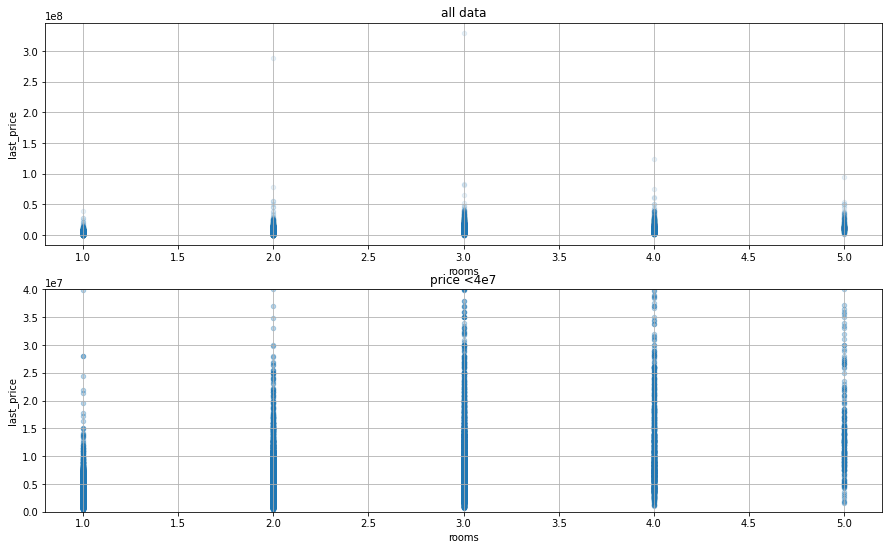

In [101]:
fig, ax = plt.subplots(2,1, figsize = (15, 9))
data.plot(kind = 'scatter', x = 'rooms', y = 'last_price', grid = True, alpha = .1, ax = ax[0], title = 'all data')
data.plot(kind = 'scatter', x = 'rooms', y = 'last_price', grid = True, alpha = .3, ylim = (0,4e7), ax = ax[1], title = 'price <4e7')
plt.show()

Посмотрим теперь,  как меняется стоимость квадратного метра от кол-ва комнат.

In [102]:
print('Цена за м2 в зависимости от кол-ва комнат')
for r in range(1,6):
    print(r, 'комнат:', data.query('rooms == @r')['m_price'].median())
    

Цена за м2 в зависимости от кол-ва комнат
1 комнат: 100000.0
2 комнат: 92500.0
3 комнат: 88750.0
4 комнат: 91614.535
5 комнат: 91531.94


Видно, что самые ликвидные квартиры (самые дорогие за м2) - это квартиры с 1 и 2 комнатами.

##### Исследование зависимости цены от  `floor_category`

Проверим, как влияет этаж на стоимость квадратного метра. Построим график боксплот.

Text(0, 0.5, 'Стоимость кв.м.')

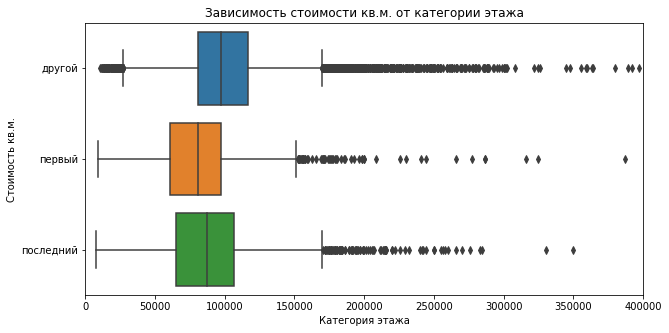

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Зависимость стоимости кв.м. от категории этажа")

sns.boxplot(data = data, x = 'm_price', y = 'floor_category')
ax.set(xlim=(0, 400000))

plt.xlabel("Категория этажа")
plt.ylabel("Стоимость кв.м.")


Видно, что квартиры на первом и последнем этажах продаются по цене за м2 ниже, чем остальные квартиры.

##### Исследование зависимости цены от  `first_day_exposition`

Для исследования зависимости цены квартиры от даты размещения создадим сводные таблицы с медианным значением стоимости кв.м. в зависимости от дня недели/месяца/года, когда было размещено объявление. 

In [104]:
display (    
     data
    .groupby('month_exposition')
    .agg(count=('m_price', 'count'),average_prices=('m_price', 'median'),average_days=('days_exposition', 'median'))
    .sort_values('average_prices', ascending = False)
)

display (    
     data
    .groupby('year_exposition')
    .agg(count=('m_price', 'count'),average_prices=('m_price', 'median'),average_days=('days_exposition', 'median'))
    .sort_values('average_prices', ascending = False)
)

display (    
     data
    .groupby('wday_exposition')
    .agg(count=('m_price', 'count'),average_prices=('m_price', 'median'),average_days=('days_exposition', 'median'))
    .sort_values('average_prices', ascending = False)
)

,count,average_prices,average_days
month_exposition,,,
4,2283,95842.960,124.0
9,1917,95592.140,89.0
8,1676,95298.645,82.0
11,2282,95194.595,74.0
1,1423,94936.710,88.5
2,2542,94680.850,88.0
3,2485,94644.970,108.0
7,1597,94285.710,92.0
10,2041,93857.140,91.0


,count,average_prices,average_days
year_exposition,,,
2014,126,106265.855,910.0
2019,2770,102849.410,23.0
2018,8195,95454.550,63.0
2017,7866,92090.370,102.0
2015,1108,92088.970,578.0
2016,2653,91135.840,237.5


,count,average_prices,average_days
wday_exposition,,,
1,4008,95173.24,94.0
2,3800,95172.19,98.0
3,4098,94729.72,95.0
0,3461,94262.30,99.0
6,1632,94202.90,88.0
4,3859,94142.86,94.0
5,1860,92862.45,94.0


- Цена кв.м. от месяца размещения объявления практически не зависит.
- Самая высокая стоимость квартира была в 2014 году (106000), после этого в период 2015-2018 годы цена кв.м. в среднем стала ниже на 10% и вновь восстановилась в 2019.
- Зависимости стоимости кв.м. квартиры от дня недели публикации объявления не наблюдается

#### Изучение топ-10 населенных пунктов

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — постройте сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [105]:
#10 населённых пунктов с наибольшим числом объявлений
locations_top10 = data.locality_name.value_counts().head(10)
locations_top10

Санкт-Петербург    15003
Мурино               569
Кудрово              449
Шушары               431
Всеволожск           390
Пушкин               351
Колпино              334
Парголово            315
Гатчина              297
Выборг               232
Name: locality_name, dtype: int64

In [106]:
top10 = (
    data
    .query('locality_name in @locations_top10.index')
    .pivot_table(index = 'locality_name', values = 'm_price', aggfunc = ['count', 'mean'])    
)
top10.columns = ['count', 'mean']
top10['mean'] = top10['mean'].round(0)
top10.sort_values(by = 'mean', ascending = False)

,count,mean
locality_name,,
Санкт-Петербург,15003,111593.0
Пушкин,351,102804.0
Кудрово,449,95358.0
Парголово,315,90033.0
Мурино,569,85847.0
Шушары,431,78305.0
Колпино,334,75492.0
Гатчина,297,69076.0
Всеволожск,390,68541.0


Самая высокая стоимость квадратного метра в Санкт-Петербург и Пушкине, а самая низкая в Выборге и Всеволжске.

#### Изучение стоимости квартир в Санкт-Петербурге в зависимости от удаленности от центра

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра. Учитывайте каждый километр расстояния: узнайте среднюю цену квартир в одном километре от центра, в двух и так далее. Опишите, как стоимость объектов зависит от расстояния до центра города — постройте график изменения средней цены для каждого километра от центра Петербурга.

<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='m_price'>

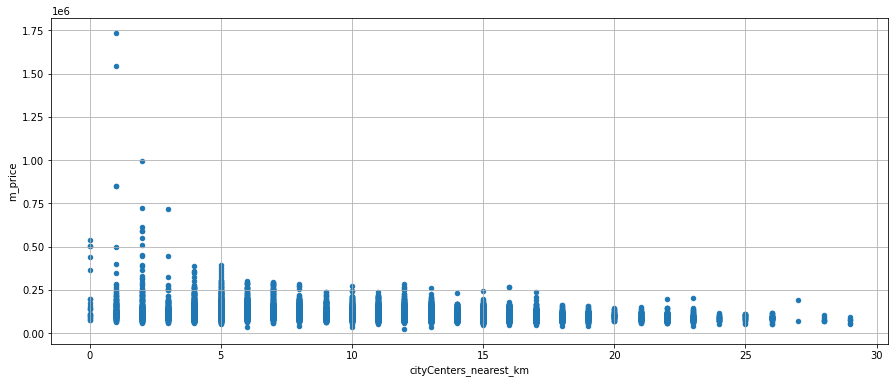

In [107]:
#график средней стоимости кв.м. в Санкт-Петербурге на разном удалении от центра
(
    data
    .query('locality_name == "Санкт-Петербург"')
    .plot(kind = 'scatter', x = 'cityCenters_nearest_km', y = 'm_price', figsize = (15,6), grid = True)
)


*Видно, что стоимость квадратного метра зависит от удаленности от центра, ниже рассмотрим подробнее*

,cityCenters_nearest_km,median,count
0,0.0,139318.890,21
1,1.0,126728.110,163
2,2.0,120711.940,264
3,3.0,109707.720,319
4,4.0,117381.095,622
5,5.0,126219.600,815
6,6.0,124475.520,527
7,7.0,122222.220,365
8,8.0,122157.620,568
9,9.0,105444.925,574


<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='median'>

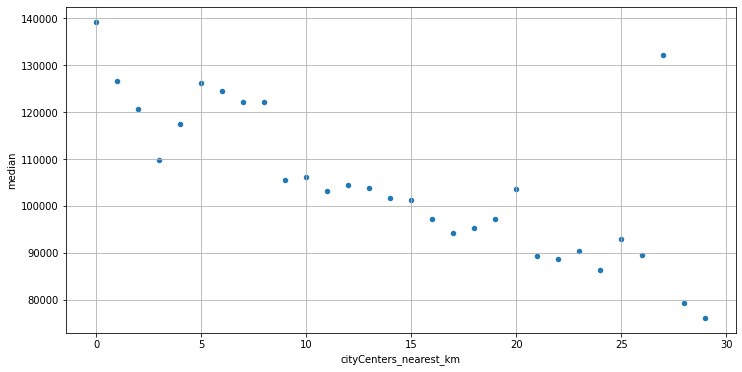

In [108]:
# как цена квадратного метра зависит от расстояния до центра города
# создадим таблицу с ценой м2 и расстоянием до центра 
m_price_per_km = (data[['cityCenters_nearest_km', 'm_price', 'locality_name']]
                .query('locality_name == "Санкт-Петербург"')
                .groupby('cityCenters_nearest_km')
                .agg(['median', 'count'])
                .reset_index()
                 )
m_price_per_km.columns = ['cityCenters_nearest_km','median', 'count']
display(m_price_per_km)          
# график изменения средней цены для каждого километра от центра Петербурга.
m_price_per_km.plot(kind = 'scatter', x = 'cityCenters_nearest_km', y ='median', grid = True, figsize = (12,6))        

Ожидаемо, чем ближе к центру, тем дороже стоит квадратный метр. Цена за м2 резко падает при удалении до 10 км от центра, затем в диапазоне 10-20 км меняется незначительно, затем падает скачком на 20 и 25 км. 

Наличие выброса в точке x = 27 объясняется тем, что для этого значения в датасете всего 2 записи

Отрицательный коэффициент корреляции -0.76 также показывает сильную отрицательную связь между расстоянием до центра и ценой квадратного метра

In [109]:
m_price_per_km['median'].corr(m_price_per_km['cityCenters_nearest_km'])

-0.7650108570458498

### Общий вывод

Для проведения исследования объявлений о продаже квартир изучали датасет с объявлениями по Ленинградской области за период с 11.2014 по 05.2019. Данные были очищены от выбросов, везде, где возможно, были заполнены пропуски, обработаны неявные дубликаты в названиях населенных пунктов. В результате предобработки данных было удалено менее 5% записей из датасета, по оставшимся 22718 записям (из 23699) проводилось исследование зависимости цены от разных параметров и  сделаны следующие выводы:
1.	Квартиры с меньшей площадью имеют большую стоимость за кв.м. по сравнению квартирами с большим метражом. Эту зависимость также можно установить по однокомнатным и двукомнатным квартирам - у них стоимость за кв.м. выше.
2.	Квартиры на первом и последнем этажах стоят в среднем дешевле, бчем остальные квартиры.
3.	Наиболее дорогие квартиры расположены в центре (до 10 км от центра), с удалением от центра стоимость квадратного метра снижается.
4.	Из 10 городов с наибольшим числом объявлений самые дорогие квартиры в Санкт-Петербурге и Пушкине. Самые дешевые квартиры в город в Выборге и Всеволжске.
5.	При удалении от центра Санкт-Петербурга стоимость кв.м. уменьшается: в центре стоимость квартиры составляет почти 140 тыс руб (медианное значение), а на расстоянии 30 км - 76 тыс.руб. - почти вдвое.
6. Самая высокая стоимость квартира была в 2014 году (106000), после этого в период 2015-2018 годы цена кв.м. в среднем стала ниже на 10% и вновь восстановилась в 2019.
